In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
sns.color_palette('viridis')
raw_data = pd.read_csv('../data/redfin_cleaned.csv')
raw_data.Price = raw_data.Price.values/10**3

In [58]:
# Drop some columns
drop_cols = ['Address',
             'KtoFiveType','KtoSixType',
             'NinetoTwelveType',
             'SeventoEightType', 'SixtoEightType',
             'Zip','Community',
             'RedfinEstimate','PricePerSqFt']
raw_data.drop(drop_cols, axis=1, inplace=True)
raw_data = raw_data.loc[raw_data.Price.notna()]
raw_data = raw_data.loc[(raw_data.Longitude<0) & (raw_data.Longitude.notna())]
raw_data = raw_data.loc[(raw_data.Latitude>0) & (raw_data.Latitude.notna())]
raw_data.shape

(11873, 38)

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Beds'}>,
        <AxesSubplot:title={'center':'SqFt'}>,
        <AxesSubplot:title={'center':'Baths'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'LotSize'}>,
        <AxesSubplot:title={'center':'GarageSpaces'}>,
        <AxesSubplot:title={'center':'ParkingSpaces'}>,
        <AxesSubplot:title={'center':'MainLevelBathrooms'}>,
        <AxesSubplot:title={'center':'MainLevelBedrooms'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'KtoFiveRating'}>,
        <AxesSubplot:title={'center':'KtoFiveDist'}>,
        <AxesSubplot:title={'center':'SixtoEightRating'}>],
       [<AxesSubplot:title={'center':'SixtoEightDist'}>,
        <AxesSubplot:title={'center':'NinetoTwelveRating'}>,
        <AxesSubplot:title={'center':'NinetoTwelveDist'}>,
        <AxesSubplot:tit

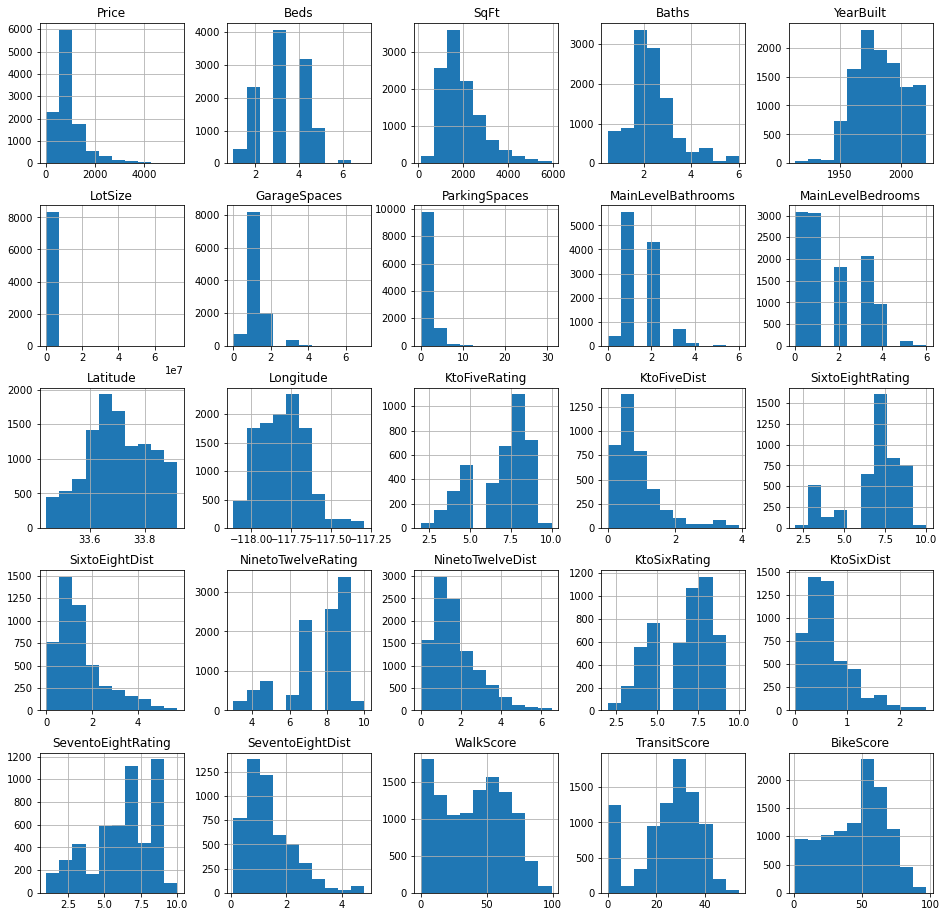

In [59]:
# Remove Outliers
cols = raw_data.columns[raw_data.dtypes!='object']
outlier_data = pd.DataFrame(index=raw_data.index)
for col in cols.drop(['Latitude','Longitude']):
    std = (raw_data[col].values - raw_data[col].mean())/raw_data[col].std()
    outlier_data[col] = std
outlier_index = outlier_data.index[(np.abs(outlier_data)>3.5).any(axis=1)]
raw_data = raw_data.drop(outlier_index, axis=0)
raw_data.hist(figsize=(16,16))

In [60]:
# Split Data
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(17)
test_size = 0.2
data_train, data_test = train_test_split(raw_data, random_state=rng, test_size=test_size)

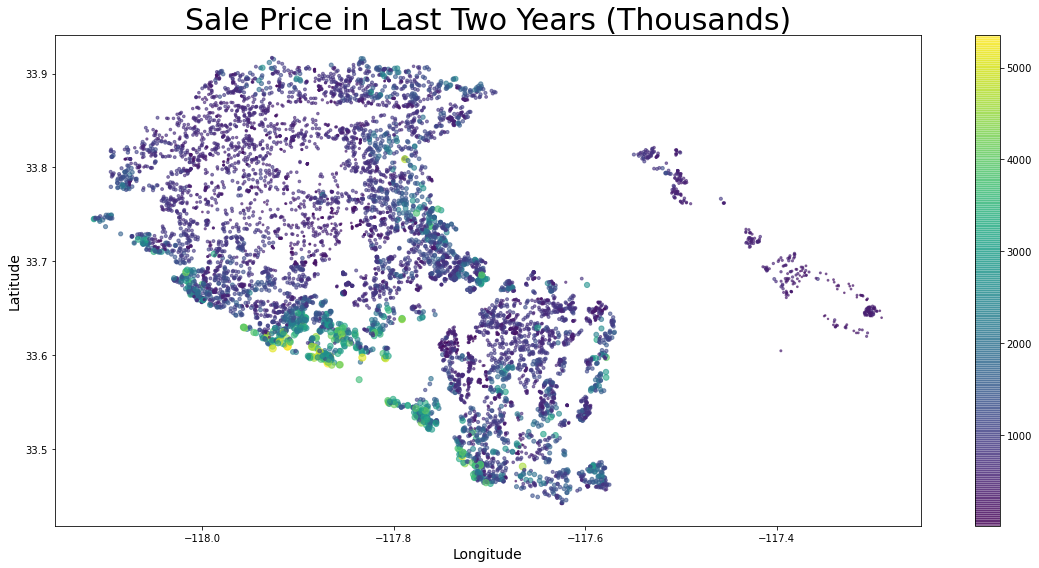

In [61]:
# Distribution of Points
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
data_train.plot(kind="scatter", 
              x="Longitude", y="Latitude", 
              alpha=0.6,
              c=data_train['Price'], 
              s=data_train['Price']/10**2,
              cmap=plt.get_cmap("viridis"), colorbar=True,
              ax=ax
)
plt.title('Sale Price in Last Two Years (Thousands)',  fontsize=30)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.tight_layout()
plt.savefig('../output/figure_1.pdf')

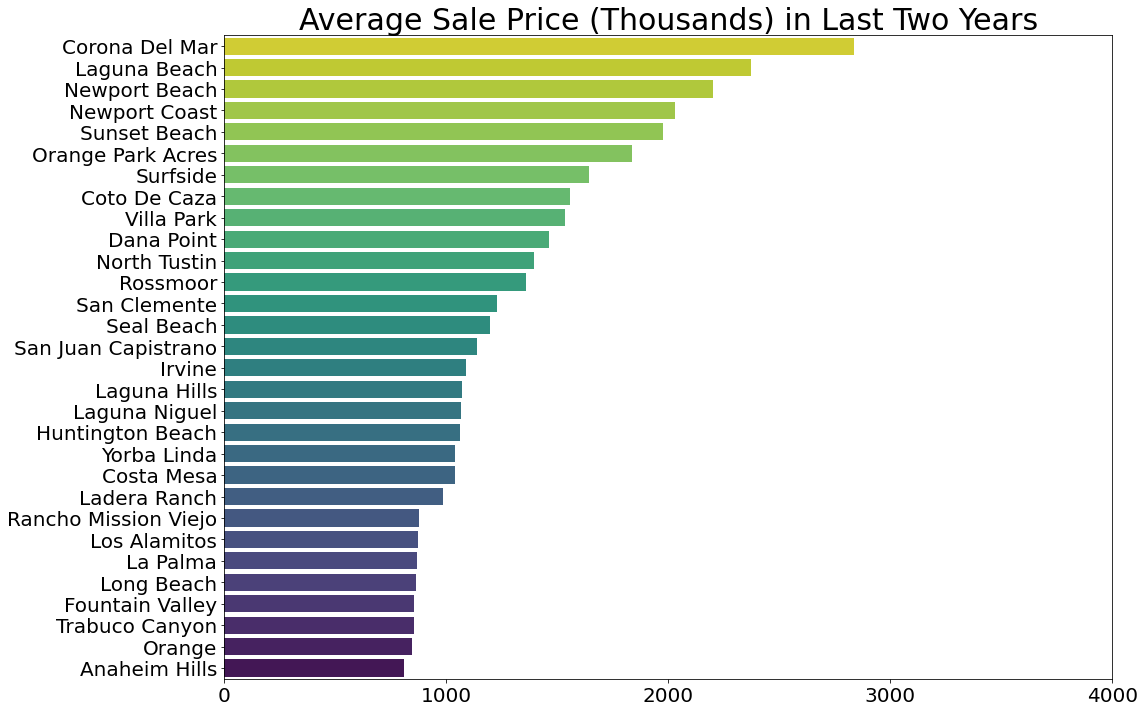

In [62]:
# Price by City
price_by_city = data_train.groupby('City').agg({'Price':'mean'},{'City':'first'})
price_by_city.sort_values('Price', inplace=True, ascending=False)
price_by_city = price_by_city.iloc[0:30,]
price_by_city.reset_index(inplace=True)
f, ax = plt.subplots(figsize=(16, 10))
sns.barplot(y = 'City', x='Price', data=price_by_city, palette='viridis_r')
ax.set_title('Average Sale Price (Thousands) in Last Two Years', fontsize=30)
ax.set_ylabel('')
ax.set_yticks(np.arange(0, len(price_by_city['City'])))
ax.set_yticklabels(price_by_city['City'], fontsize=20)
ax.set_xlabel('')
ax.set_xticks(np.arange(0,5000,1000))
ax.set_xticklabels(np.arange(0,5000,1000), fontsize=20)
f.tight_layout()
f.savefig('../output/figure_2.pdf')

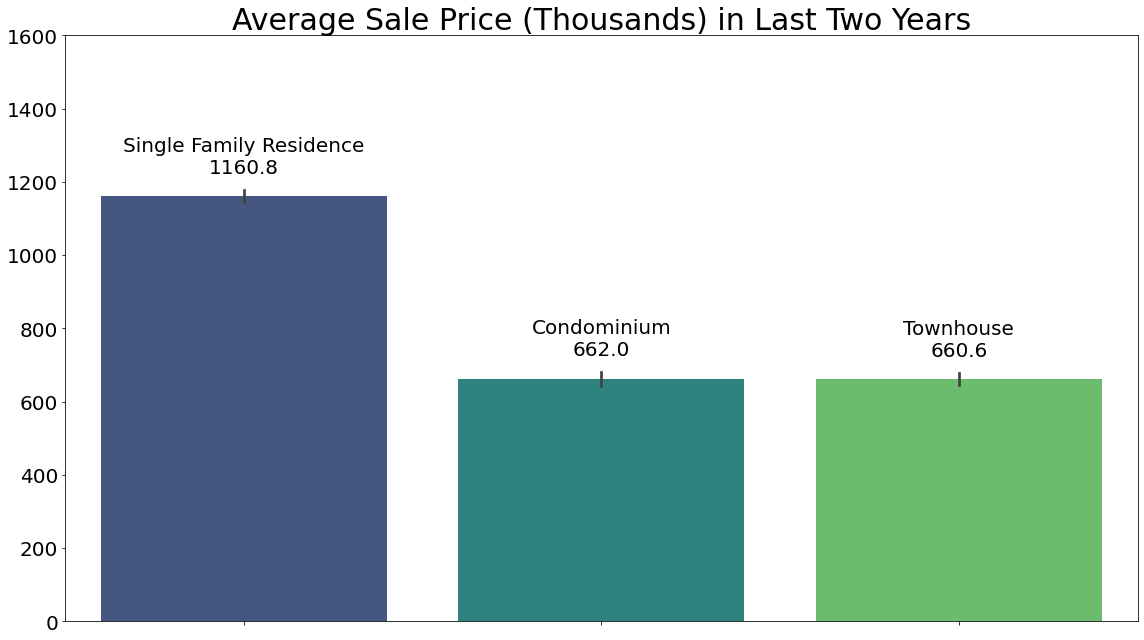

In [63]:
# Single Family Home
f, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x='PropertyType', y='Price', data=data_train, palette='viridis')
ax.set_title('Average Sale Price (Thousands) in Last Two Years', fontsize=30)
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticks(np.arange(0,1800,200))
ax.set_yticklabels(np.arange(0,1800,200), fontsize=20)
for a,b in zip(data_train.PropertyType.dropna().unique(), ax.patches):
    ax.annotate(a + '\n' + format(b.get_height(), '.1f'), 
                (b.get_x() + b.get_width() / 2., b.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 40), fontsize=20,
                textcoords = 'offset points')
f.tight_layout()
f.savefig('../output/figure_3.pdf')

<AxesSubplot:xlabel='Baths', ylabel='Proportion'>

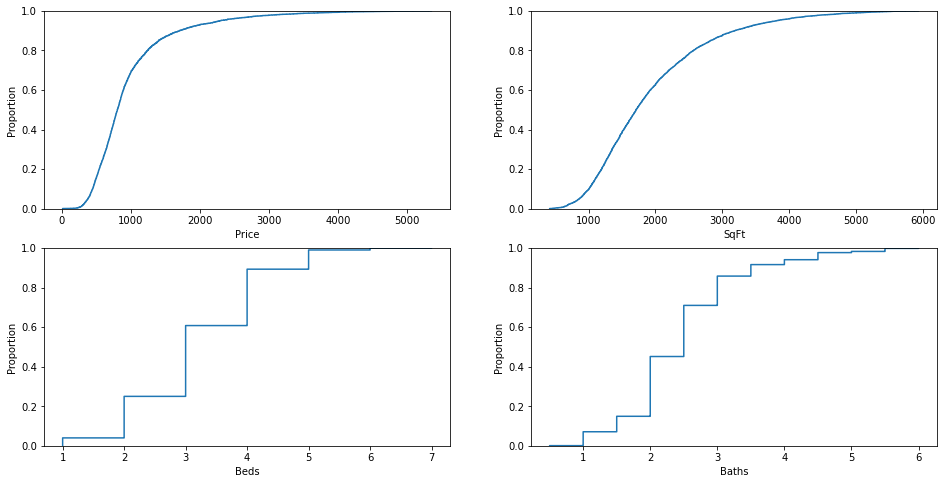

In [64]:
# Price Looks Much Better with Trimmed Data
f, ax = plt.subplots(2,2,figsize=(16,8))
sns.ecdfplot(data_train, x="Price", ax=ax[0,0])
sns.ecdfplot(data_train, x="SqFt", ax=ax[0,1])
sns.ecdfplot(data_train, x="Beds", ax=ax[1,0])
sns.ecdfplot(data_train, x="Baths", ax=ax[1,1])

<ipython-input-65-960a07674277>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,8000,100), fontsize=20)
<ipython-input-65-960a07674277>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,3000,500), fontsize=20)


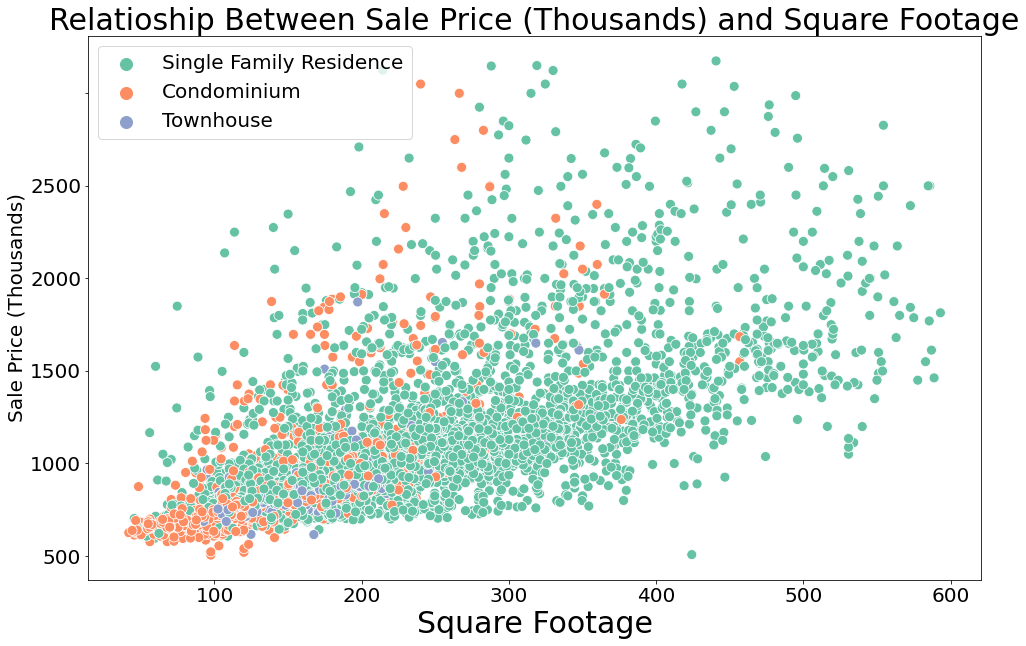

In [65]:
# Overview of Key Data
f, ax = plt.subplots(figsize = (16,10))
sns.scatterplot(x='SqFt', y = 'Price', 
                hue="PropertyType", palette='Set2',
                s=100,
                data=data_train)
ax.set_title('Relatioship Between Sale Price (Thousands) and Square Footage', fontsize=30)
ax.set_xticklabels(np.arange(0,8000,100), fontsize=20)
ax.set_yticklabels(np.arange(0,3000,500), fontsize=20)
ax.set_xlabel("Square Footage",fontsize=30)
ax.set_ylabel("Sale Price (Thousands)",fontsize=20)
ax.legend(markerscale=2,fontsize=20)
f.savefig('../output/figure_4.pdf')

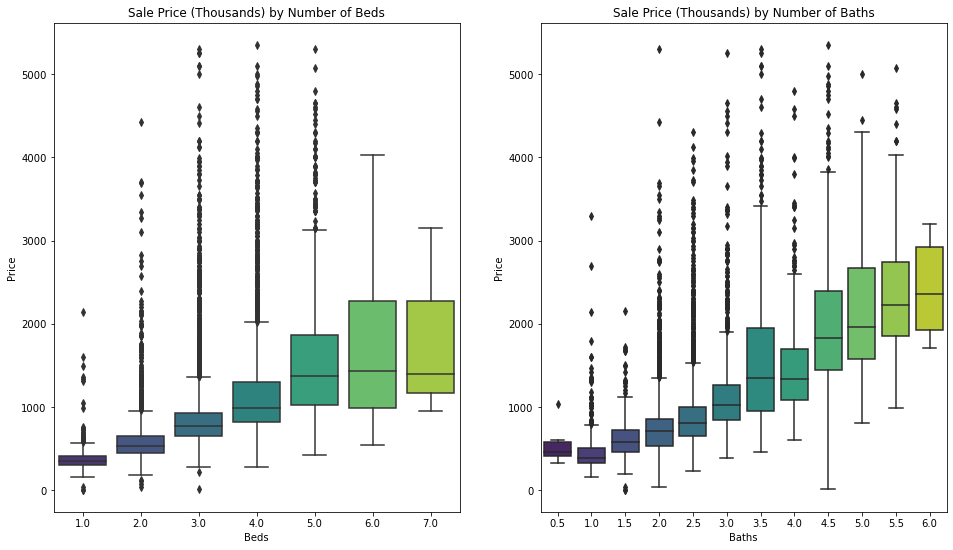

In [66]:
# Boxplot Baths and Beds
f, ax = plt.subplots(1,2, figsize=(16, 9))
ax[0].set_title('Sale Price (Thousands) by Number of Beds')
ax[1].set_title('Sale Price (Thousands) by Number of Baths')
sns.boxplot(x ='Beds', y ='Price', data = data_train, ax=ax[0], palette='viridis')
sns.boxplot(x ='Baths', y ='Price', data = data_train, ax=ax[1], palette='viridis')
f.savefig('../output/figure_5.pdf')

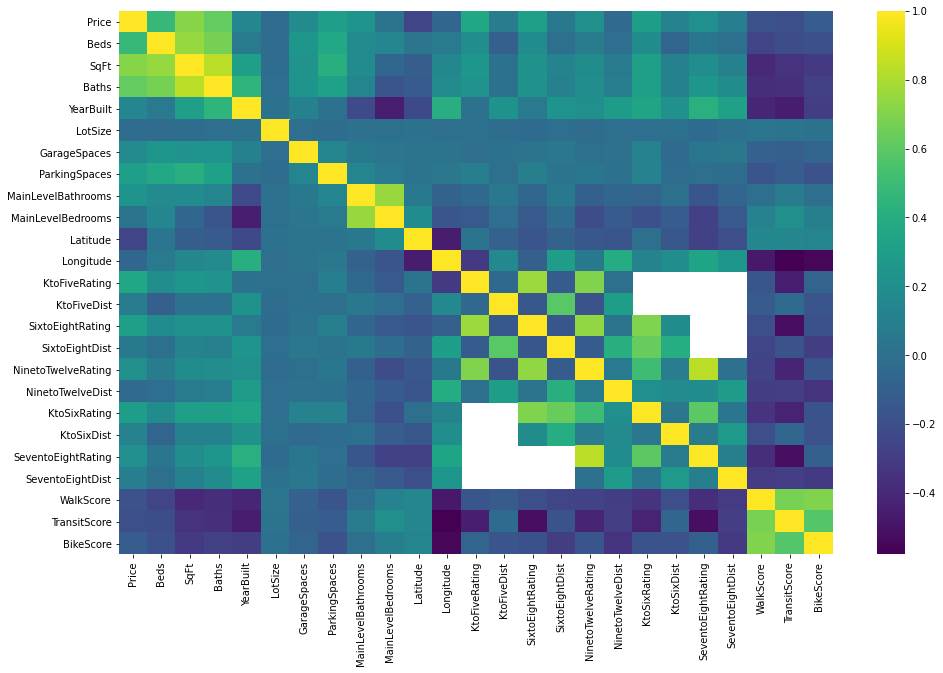

In [51]:
# Boxplot Scores
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data_train.corr(), cmap='viridis');
#f.savefig('../output/figure_5.pdf')